In [1]:
# Importing necessary libraries

# Building deep learning models
import tensorflow as tf 
from tensorflow import keras 
# For accessing pre-trained models

# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
from PIL import Image

import os
import numpy as np
import pathlib

In [6]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt

In [7]:
im_shape = (128,128)

TRAINING_DIR = 'ArTaxOr_64x64/train'
TEST_DIR = 'ArTaxOr_64x64/test'

seed = 7

BATCH_SIZE = 64

In [8]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [9]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 11070 images belonging to 7 classes.
Found 2763 images belonging to 7 classes.
Found 1538 images belonging to 7 classes.
Classes: ['Araneae', 'Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Odonata']


In [11]:
base_model = InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
base_model.trainable = False

optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
epochs = 3

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.keras',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/3


172/172 [==============================] - ETA: 0s - loss: 1.6639 - accuracy: 0.3662
Epoch 1: val_loss improved from inf to 1.48810, saving model to model.keras
172/172 [==============================] - 291s 2s/step - loss: 1.6639 - accuracy: 0.3662 - val_loss: 1.4881 - val_accuracy: 0.4549
Epoch 2/3
172/172 [==============================] - ETA: 0s - loss: 1.5416 - accuracy: 0.4184
Epoch 2: val_loss did not improve from 1.48810
172/172 [==============================] - 261s 2s/step - loss: 1.5416 - accuracy: 0.4184 - val_loss: 1.4907 - val_accuracy: 0.4491
Epoch 3/3
172/172 [==============================] - ETA: 0s - loss: 1.5151 - accuracy: 0.4288
Epoch 3: val_loss did not improve from 1.48810
172/172 [==============================] - 266s 2s/step - loss: 1.5151 - accuracy: 0.4288 - val_loss: 1.4887 - val_accuracy: 0.4549


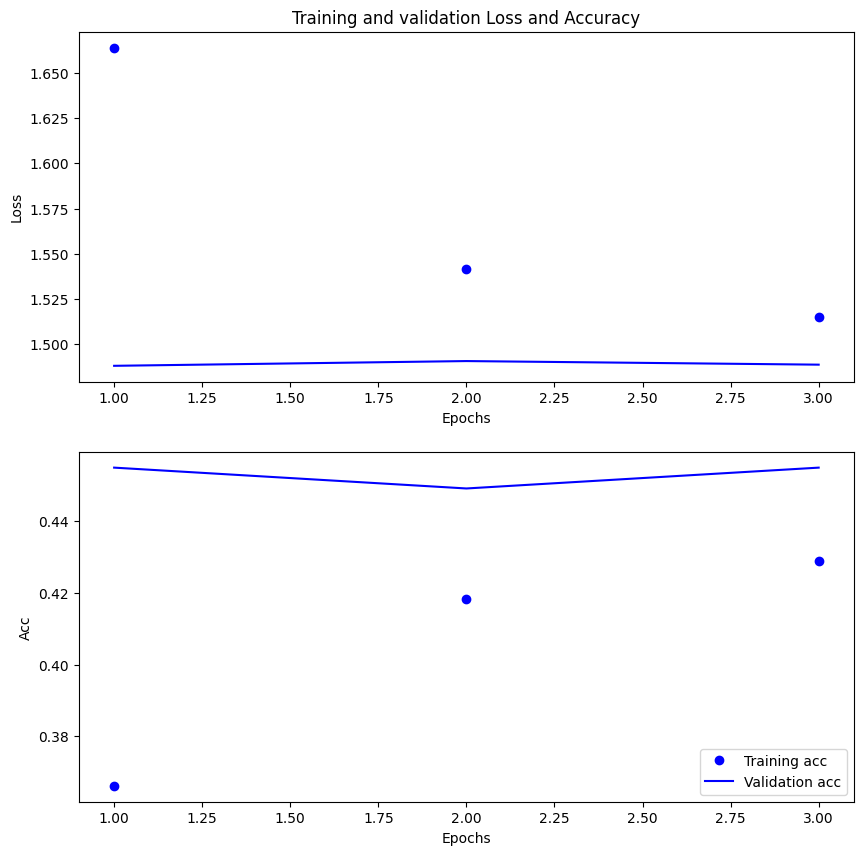

In [13]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [14]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.keras')

In [15]:
score = model.evaluate(validation_generator)  # Assuming validation_generator is a generator of validation data
print('Val loss:', score[0])
print('Val accuracy:', score[1])


44/44 [==============================] - 56s 1s/step - loss: 1.4866 - accuracy: 0.4553
Val loss: 1.4865608215332031
Val accuracy: 0.4553022086620331


In [16]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 [==============================] - 33s 1s/step - loss: 1.4819 - accuracy: 0.4337
Test loss: 1.4819464683532715
Test accuracy: 0.43368011713027954


In [17]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

25/25 [==============================] - 32s 1s/step
Classification Report
              precision    recall  f1-score   support

     Araneae       0.40      0.49      0.44       239
  Coleoptera       0.52      0.28      0.37       217
     Diptera       0.37      0.22      0.27       227
   Hemiptera       0.37      0.55      0.45       225
 Hymenoptera       0.30      0.16      0.20       192
 Lepidoptera       0.44      0.51      0.47       204
     Odonata       0.56      0.78      0.65       234

    accuracy                           0.43      1538
   macro avg       0.42      0.43      0.41      1538
weighted avg       0.43      0.43      0.41      1538



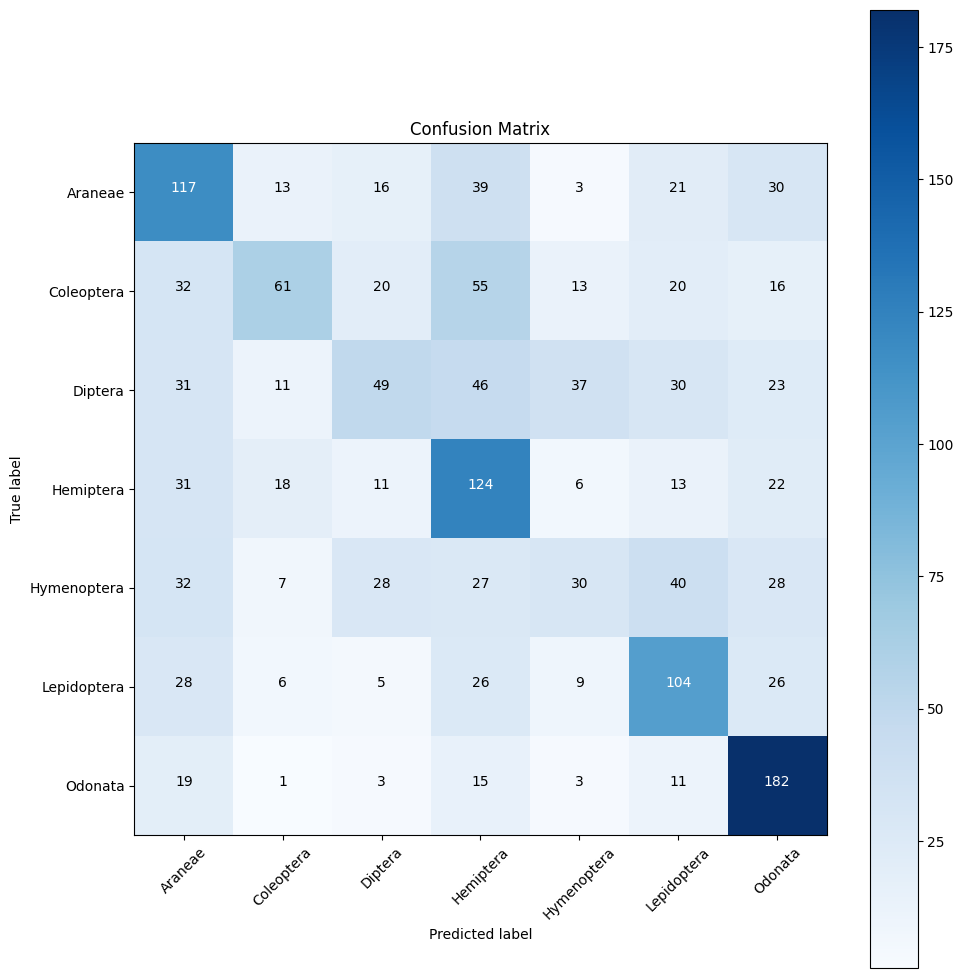

In [18]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))